# Load in LAI files

In [1]:
import re
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from netCDF4 import Dataset
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd

# Directory containing the .nc files
data_dir = '/global/scratch/users/liuwenjin021011/data/NOAA_LAI/'
nc_files = []
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith('.nc'):
            nc_files.append(os.path.join(root, file))
print(len(nc_files))

1088


In [2]:
# load in the first file to setup functions

print(nc_files[0].split('NOAA_LAI/')[1])
first_file_path = nc_files[0]
dataset = Dataset(first_file_path, 'r')  # 'r' is for read mode

print(dataset.variables.keys())

AVHRR-Land_v005-preliminary_AVH15C1_NOAA-19_20180222_c20180815200159.nc
dict_keys(['latitude', 'longitude', 'time', 'crs', 'lat_bnds', 'lon_bnds', 'LAI', 'FAPAR', 'QA'])


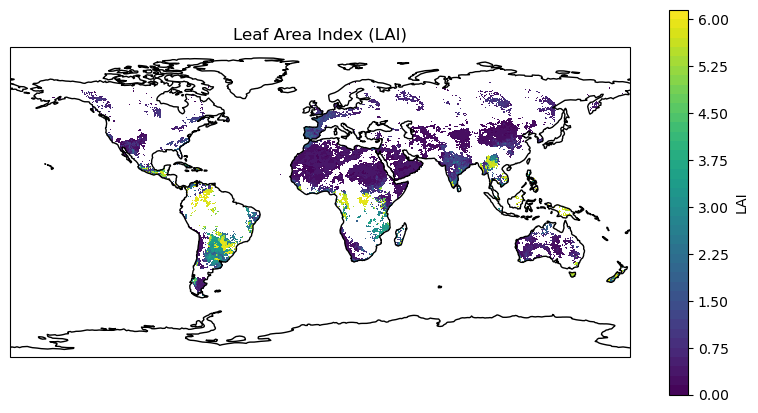

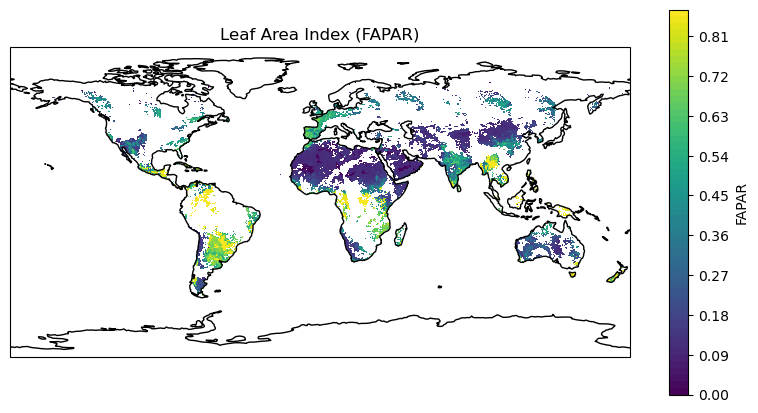

In [3]:
# Visualize the first dataset to get the idea of the locations being included in NOAA_LAI data

latitude = dataset.variables['latitude'][:]
longitude = dataset.variables['longitude'][:]
LAI = dataset.variables['LAI'][0, :, :]  # Assuming time is the first dimension
FAPAR = dataset.variables['FAPAR'][0, :, :]

def Visualize_on_Geo_Map(latitude, longitude, variable, data):
    plt.figure(figsize=(10, 5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_global()

    plt.contourf(longitude, latitude, data, 60, transform=ccrs.PlateCarree())
    plt.colorbar(label= f'{variable}')
    plt.title(f'Leaf Area Index ({variable})')
    plt.show()
    
Visualize_on_Geo_Map(latitude, longitude, 'LAI', LAI)
Visualize_on_Geo_Map(latitude, longitude, 'FAPAR', FAPAR)

In [4]:
# filter the Area of Interest in China only, and plot the filter map to double check

def filter_for_china_shapefile(nc_file_path, shapefile_path):
    # Load NetCDF file
    dataset = Dataset(nc_file_path, 'r')
    latitudes = dataset.variables['latitude'][:]
    longitudes = dataset.variables['longitude'][:]
    LAI = dataset.variables['LAI'][0, :, :]  # Taking the first time slice
    FAPAR = dataset.variables['FAPAR'][0, :, :]
    dataset.close()

    # Prepare coordinates for each point and flatten LAI data
    lon, lat = np.meshgrid(longitudes, latitudes)
    LAI_flat = LAI.ravel()
    FAPAR_flat = FAPAR.ravel()

    df = pd.DataFrame({
        'Latitude': lat.ravel(),
        'Longitude': lon.ravel(),
        'LAI': LAI_flat, 
        'FAPAR': FAPAR_flat
    })
    df = df.dropna()

    # print("DataFrame size after dropping NaNs:", df.shape)

    # Convert DataFrame to GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
    gdf.set_crs(epsg=4326, inplace=True)

    # print("Checking CRS of shapefile...")
    china_shape = gpd.read_file(shapefile_path)
    # print("Shapefile CRS:", china_shape.crs)

    # Perform spatial join
    filtered_gdf = gpd.sjoin(gdf, china_shape, how='inner', op='intersects')

    # print("Filtered GeoDataFrame size:", filtered_gdf.shape)
    return filtered_gdf[['Latitude', 'Longitude', 'LAI', 'FAPAR']]

nc_file_path = nc_files[0]
shapefile_path = '/global/home/users/liuwenjin021011/logs/fall_2023/China-Doundary-Shape.shp'
filtered_data = filter_for_china_shapefile(nc_file_path, shapefile_path)


/global/home/users/liuwenjin021011/.conda/envs/NOx_selina/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3442: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/tmp/ipykernel_20637/2859097259.py:36: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  filtered_gdf = gpd.sjoin(gdf, china_shape, how='inner', op='intersects')


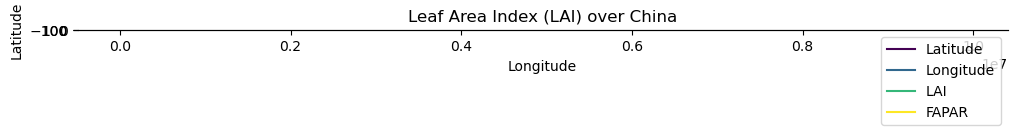

In [5]:
def plot_lai_on_map(filtered_gdf):
    """
    Plot LAI data on a map with smaller dot size.

    Parameters:
    filtered_gdf (GeoDataFrame): Filtered GeoDataFrame with LAI data.
    """
    # Create a figure and axis with a map projection
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plotting the shape of the world for context
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    world.plot(ax=ax, color='white', edgecolor='black')

    # Plotting the LAI data with smaller dots
    # Adjust the markersize as needed
    filtered_gdf.plot(column='LAI', ax=ax, legend=True, cmap='viridis', markersize=0.1)

    plt.title('Leaf Area Index (LAI) over China')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.show()

plot_lai_on_map(filtered_data)


# Filter Area of Interest in LAI Files

In [6]:
from tqdm import tqdm
import warnings

def filter_nc_files_by_date(nc_files, year):

    filtered_files = []
    # Creating a regex pattern to match the file format
    pattern = re.compile(f'.*NOAA-19_{year}.*\.nc$')

    for file in nc_files:
        if pattern.match(file):
            filtered_files.append(file)

    return filtered_files

filtered_files_2017 = filter_nc_files_by_date(nc_files, '2017')  
filtered_files_2018 = filter_nc_files_by_date(nc_files, '2018')
filtered_files_2019 = filter_nc_files_by_date(nc_files, '2019')


In [7]:

def create_combined_dataframe(nc_files, shapefile_path):
    all_filtered_dfs = []

    # Use tqdm for progress tracking
    for nc_file_path in tqdm(nc_files, desc='Creating combined dataframe'):
        # Suppress warnings
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            filtered_df = filter_for_china_shapefile(nc_file_path, shapefile_path)
        
        time = nc_file_path.split('NOAA-19_')[1].split('_c20')[0]
        year, month, day = time[:4], time[4:6], time[6:8]
        filtered_df['Year'] = [year] * filtered_df.shape[0]
        filtered_df['Month'] = [month] * filtered_df.shape[0]
        filtered_df['Day'] = [day] * filtered_df.shape[0]
        all_filtered_dfs.append(filtered_df)

    total_df = pd.concat(all_filtered_dfs, ignore_index=True)

    return total_df



# Usage
shapefile_path = '/global/home/users/liuwenjin021011/logs/fall_2023/China-Doundary-Shape.shp'

In [8]:
# total_df.to_csv('/global/scratch/users/liuwenjin021011/data/NOAA_LAI/China_Filtered_2017.csv', index = False, header = True)

In [ ]:
total_df_2017 = create_combined_dataframe(filtered_files_2017, shapefile_path)
total_df_2017.to_csv('/global/scratch/users/liuwenjin021011/data/NOAA_LAI/China_Filtered_2017.csv', index = False, header = True)
# total_df_2017 = pd.read_csv('/global/scratch/users/liuwenjin021011/data/NOAA_LAI/China_Filtered_2017.csv')
# total_df_2017.shape

Creating combined dataframe:  71%|███████   | 255/358 [4:32:54<1:35:37, 55.70s/it]

In [ ]:
total_df_2018 = create_combined_dataframe(filtered_files_2018, shapefile_path)
total_df_2018.to_csv('/global/scratch/users/liuwenjin021011/data/NOAA_LAI/China_Filtered_2018.csv', index = False, header = True)
# total_df_2018 = pd.read_csv('/global/scratch/users/liuwenjin021011/data/NOAA_LAI/China_Filtered_2018.csv')
# total_df_2018.shape

In [ ]:
total_df_2019 = create_combined_dataframe(filtered_files_2019, shapefile_path)
total_df_2019.to_csv('/global/scratch/users/liuwenjin021011/data/NOAA_LAI/China_Filtered_2019.csv', index = False, header = True)
# total_df_2019 = pd.read_csv('/global/scratch/users/liuwenjin021011/data/NOAA_LAI/China_Filtered_2019.csv')#
# total_df_2019.shape

In [8]:
pd.read_csv('/global/scratch/users/liuwenjin021011/data/NOAA_LAI/China_Filtered_2019.csv')

,Latitude,Longitude,LAI,FAPAR,Year,Month,Day
0,52.725000,124.824980,0.000,0.000,2019,2,12
1,52.625000,123.625000,0.000,0.000,2019,2,12
2,49.925000,118.725006,0.095,0.076,2019,2,12
3,49.324997,117.725006,0.042,0.104,2019,2,12
4,48.975000,116.774994,0.089,0.062,2019,2,12
...,...,...,...,...,...,...,...
16080969,25.025002,113.875000,0.226,0.186,2019,11,24
16080970,24.824997,113.975006,0.000,0.000,2019,11,24
16080971,18.875000,109.424990,0.000,0.000,2019,11,24
16080972,18.875000,109.475006,0.000,0.000,2019,11,24
